/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


<function matplotlib.pyplot.show>

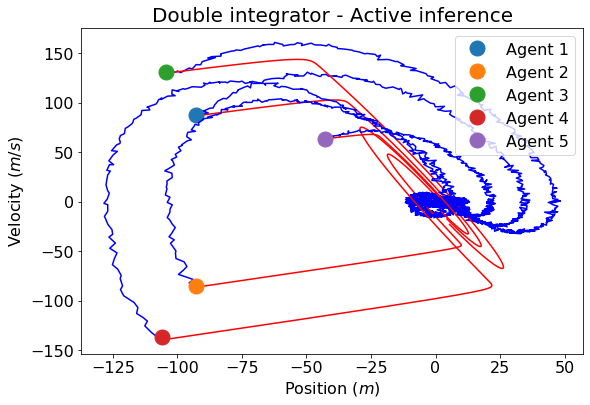

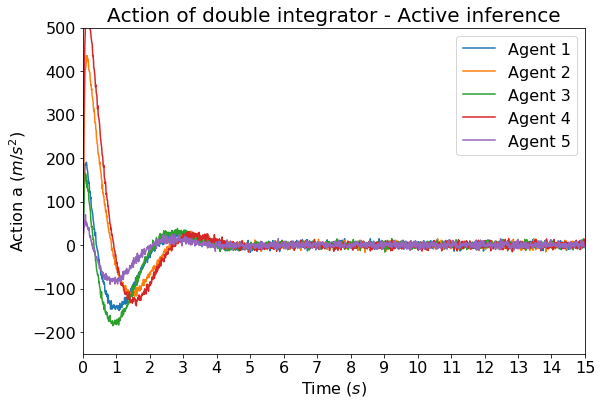

In [ ]:
#Code for the double integrator experiments from Manuel Baltieri's PhD thesis

import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as splin
from autograd import grad

### define font size for plots ###
#
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)            # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)     # fontsize of the figure title
#

dt = .01

gamma = 1                                                   # drift in OU process (if you want to simulate coloured noise)
plt.close('all')
small_value = np.exp(-50)

obs_states = 3
hidden_states = 3                                           # x, in Friston's work
hidden_causes = 3                                           # v, in Friston's work
temp_orders_states = 2                                      # generalised coordinates for hidden states x, but only using n-1
temp_orders_causes = 2                                      # generalised coordinates for hidden causes v (or \eta in biorxiv manuscript), but only using n-1

# parameters for double integrator
A = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])               # state transition matrix
B = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])                     # input matrix
C = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])               # noise dynamics matrix
D = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
H = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])               # measurement matrix


### FUNCTIONS ###

## if using bounded control, not working at the moment ##

def sigmoid(x):
#    return x
    return np.tanh(x)

def dsigmoid(x):
#    return x
    return 1 - np.tanh(x)**2


## free energy functions ##
# generative process
def g(x, v):
    return np.dot(H, x)

def f(x, v, a):
    return np.dot(A, x) + np.dot(B, a) + np.dot(B, v)
#    return np.dot(A, x) + np.dot(B, sigmoid(a)) + np.dot(B, v)

# generative model
def g_gm(x, v, H_gm):
    return np.dot(H_gm, x)

def f_gm(x, v, A_gm, B_gm):
    # no action in generative model, a = 0.0
    return np.dot(A_gm, x) + np.dot(B_gm, v)

def getObservation(x, v, a, w):
    x[:, 1:] = f(x[:, :-1], v, a) + np.dot(C, w[:, None])
    x[:, 0] += dt * x[:, 1]
#    return g(x[:, 1:], v)
    return g(x, v)

#def F(psi, mu_x, eta, mu_pi_z, mu_pi_w):
#    return .5 * np.dot(np.dot((psi - np.dot(H_gm, mu_x[:, :-2])).transpose(), mu_pi_z), (psi - np.dot(H_gm, mu_x[:, :-2]))) + \
#                np.dot(np.dot((mu_x[:, 1:-1] - f_gm(mu_x[:, :-2], eta)).transpose(), mu_pi_w), (mu_x[:, 1:-1] - f_gm(mu_x[:, :-2], eta))) - \
#                np.trace(np.log(mu_pi_z * mu_pi_w))
                
def F(psi, mu_x, eta, mu_pi_z, mu_pi_w, A_gm, B_gm, H_gm):
    return .5 * np.dot(np.dot((psi - np.dot(H_gm, mu_x[:, :-1])).transpose(), mu_pi_z), (psi - np.dot(H_gm, mu_x[:, :-1]))) + \
                np.dot(np.dot((mu_x[:, 1:] - f_gm(mu_x[:, :-1], eta, A_gm, B_gm)).transpose(), mu_pi_w), (mu_x[:, 1:] - f_gm(mu_x[:, :-1], eta, A_gm, B_gm))) - \
                np.trace(np.log(mu_pi_z * mu_pi_w))
    
def mode_path(mu_x):
    return np.dot(mu_x, np.eye(temp_orders_states, k=-1))

def doubleIntAI(simulation, iterations):    
    # environment parameters
    x = np.zeros((hidden_states, temp_orders_states))           # position
    
    v = np.zeros((hidden_causes, temp_orders_states - 1))
    y = np.zeros((obs_states, temp_orders_states))
    eta = np.zeros((hidden_causes, temp_orders_states - 1))

    
    ### free energy variables
    # parameters for generative model
    if simulation == 0:
        alpha = np.exp(2)
        alpha2 = np.exp(1)
    elif simulation == 1:
        alpha = np.exp(1)
        alpha2 = np.exp(.5)
    elif simulation == 2:
        alpha = np.exp(-1)
        alpha2 = np.exp(0)
    elif simulation == 3:
        alpha = np.exp(2)
        alpha2 = np.exp(1)
    
    beta = np.exp(1)
    
    
    A_gm = np.array([[0, 1, 0], [-alpha, -alpha2, 0], [0, 0, 0]])               # state transition matrix
    B_gm = np.array([[0, 0, 0], [0, beta, 0], [0, 0, 0]])                     # input matrix
    H_gm = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])               # measurement matrix
    
    # actions
    a = np.zeros((hidden_states, temp_orders_states - 1))
    
    # states
    mu_x = np.zeros((hidden_states, temp_orders_states))
    
    # inputs
    v = np.zeros((hidden_causes, temp_orders_causes - 1))
    
    # minimisation variables and parameters
    dFdmu_x = np.zeros((hidden_states, temp_orders_states))
    Dmu_x = np.zeros((hidden_states, temp_orders_states))
    
    k_mu_x = 1                                                  # learning rate perception
    k_a = np.exp(14)                                                     # learning rate action
    
    # noise on sensory input (world - generative process)
    gamma_z = 0 * np.ones((obs_states, obs_states))    # log-precisions
    #gamma_z[:,1] = gamma_z[:,0] - np.log(2 * gamma)
    pi_z = np.zeros((obs_states, obs_states))
    np.fill_diagonal(pi_z, np.exp(gamma_z))
    sigma_z = np.linalg.inv(splin.sqrtm(pi_z))
    z = np.random.randn(iterations, obs_states)
    
    # noise on motion of hidden states (world - generative process)
    gamma_w = 2                                                  # log-precision
    pi_w = np.zeros((hidden_states, hidden_states))
    np.fill_diagonal(pi_w, np.exp(gamma_w))
    sigma_w = np.linalg.inv(splin.sqrtm(pi_w))
    w = np.random.randn(iterations, hidden_states)
    
    
    # agent's estimates of the noise (agent - generative model)
    mu_gamma_z = -8 * np.identity((obs_states))    # log-precisions
    mu_gamma_z[1, 1] = mu_gamma_z[0, 0] - np.log(2 * gamma)
    mu_gamma_z[2, 2] = mu_gamma_z[1, 1] - np.log(2 * gamma)
    mu_pi_z = np.exp(mu_gamma_z) * np.identity((obs_states))
    
    mu_gamma_w = -1 * np.identity((hidden_states))   # log-precision
    mu_gamma_w[1, 1] = mu_gamma_w[0, 0] - np.log(2 * gamma)
    mu_gamma_w[2, 2] = mu_gamma_w[1, 1] - np.log(2 * gamma)
    mu_pi_w = np.exp(mu_gamma_w) * np.identity((hidden_states))
    
    
    # history
    y_history = np.zeros((iterations, obs_states, temp_orders_states))
    psi_history = np.zeros((iterations, obs_states, temp_orders_states - 1))
    mu_x_history = np.zeros((iterations, hidden_states, temp_orders_states))
    a_history = np.zeros((iterations, obs_states, temp_orders_states))    
    FE_history = np.zeros((iterations,))
    v_history = np.zeros((iterations, hidden_causes, temp_orders_states - 1))
    
    x = 300 * np.random.rand(hidden_states, temp_orders_states) - 150
    x[1,0] = x[0,1]
    x[2,0] = x[1,1]
    x[2,1] = 0.
    
    # if the initialisation is too random, then this agent becomes ``disillusioned''
    mu_x[0, 0] = x[0, 0] + .1*np.random.randn()
    mu_x[1, 0] = x[0, 1] + .1*np.random.randn()
    mu_x[0, 1] = mu_x[1, 0]
    
    # automatic differentiation
    dFdmu_states = grad(F, 1)
    
    for i in range(iterations - 1):
        if simulation == 3 and i >= iterations/2:
            v[1,0] = 50
        
        mu_x_history[i, :, :] = mu_x                # save it at the very beginning since the first jump is rather quick
        
        y[:, :] = getObservation(x, v, a, np.dot(np.dot(C, sigma_w), w[i, :]))
        y[2, 0] = y[1, 1]                           # manually assign the acceleration as observed by the agent
        
        psi = y[:,:-1] + np.dot(np.dot(D, sigma_z), z[i, :, None])
        
        ### minimise free energy ###
        # perception
        dFdmu_x = dFdmu_states(psi, mu_x, eta, mu_pi_z, mu_pi_w, A_gm, B_gm, H_gm)
        Dmu_x = mode_path(mu_x)
        
        # action
        dFdy = np.dot(mu_pi_z, (psi - mu_x[:, :-1]))
        dyda = np.ones((obs_states, temp_orders_states - 1))
        
        # save history
        y_history[i, :] = y
        psi_history[i, :] = psi
        mu_x_history[i, :, :] = mu_x
        a_history[i] = a
        v_history[i] = v
        
        FE_history[i] = F(psi, mu_x, eta, mu_gamma_z, mu_pi_w, A_gm, B_gm, H_gm)
        
        
        # update equations
        mu_x += dt * k_mu_x * (Dmu_x - dFdmu_x)
        a[1, 0] += dt * - k_a * dyda.transpose().dot(dFdy)
    
    return psi_history, mu_x_history, a_history, v_history

simulation = 0
# 0: high spring stifness, strong damping
# 1: intermediate spring stifness, intermediate damping
# 2: low spring stifness, weak damping
# 3: as in simulation 0, but now we introduce an external force not modeled by the agent

T = 15
iterations = int(T / dt)

simulations_n = 5
psi_history = np.zeros((simulations_n, iterations, obs_states, temp_orders_states))
mu_x_history = np.zeros((simulations_n, iterations, hidden_states, temp_orders_states))
a_history = np.zeros((simulations_n, iterations, hidden_states, temp_orders_states))
v_history = np.zeros((simulations_n, iterations, hidden_causes, temp_orders_states - 1))

plt.figure(figsize=(9, 6))
plt.title('Double integrator - Active inference')
plt.xlabel('Position ($m$)')
plt.ylabel('Velocity ($m/s$)')
for k in range(simulations_n):
    psi_history[k,:,:,:], mu_x_history[k,:,:,:], a_history[k,:,:,:], v_history[k,:,:,:] = doubleIntAI(simulation, iterations)
    plt.plot(psi_history[k,:-1, 0, 0], psi_history[k,:-1, 1, 0], 'b')
    plt.plot(mu_x_history[k, :-1, 0, 0], mu_x_history[k, :-1, 1, 0], 'r')
    plt.plot(psi_history[k, 0, 0, 0], psi_history[k, 0, 1, 0], 'o', markersize = 15, label='Agent ' + str(k+1))
plt.legend(loc=1)

plt.figure(figsize=(9, 6))
plt.title('Action of double integrator - Active inference')
plt.xlabel('Time ($s$)')
plt.ylabel('Action a ($m/s^2$)')
for k in range(simulations_n):
    plt.plot(np.arange(0, T-dt, dt), a_history[k,:-1,1,0], label='Agent ' + str(k+1))
if simulation == 3:
    plt.plot(np.arange(0, T-dt, dt), v_history[2,:-1,1,0], 'k', label='Ext. force')
plt.xlim(0, T)
plt.ylim(-250, 500)
if simulation == 3:
    plt.xticks(np.arange(0, T+1, 2))
else:
    plt.xticks(np.arange(0, T+1, 1))
plt.legend(loc=1)

plt.show